# Plot task block structure for fMRI data

## Takuya Ito
#### 12/07/2019

In [410]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import multiprocessing as mp
import scipy.stats as stats
os.environ['OMP_NUM_THREADS'] = str(1)
import statsmodels.sandbox.stats.multicomp as mc
import sklearn
import seaborn as sns
plt.style.use("ggplot")
sns.set_style('whitegrid')
plt.rcParams["font.family"] = "FreeSans"
import nibabel as nib
import pandas as pd
import sys
sys.path.append('glmScripts/')
import taskGLMPipeline as tgp
import h5py
import dimensionality
sys.path.append('bctpy/')
import bct

## Set-up subject list and construct global variables

In [2]:
## Exploratory subjects
subjNums = ['178950','189450','199453','209228','220721','298455','356948','419239','499566','561444','618952','680452','757764','841349','908860',
            '103818','113922','121618','130619','137229','151829','158035','171633','179346','190031','200008','210112','221319','299154','361234',
            '424939','500222','570243','622236','687163','769064','845458','911849','104416','114217','122317','130720','137532','151930','159744',
            '172029','180230','191235','200614','211316','228434','300618','361941','432332','513130','571144','623844','692964','773257','857263',
            '926862','105014','114419','122822','130821','137633','152427','160123','172938','180432','192035','200917','211417','239944','303119',
            '365343','436239','513736','579665','638049','702133','774663','865363','930449','106521','114823','123521','130922','137936','152831',
            '160729','173334','180533','192136','201111','211619','249947','305830','366042','436845','516742','580650','645450','715041','782561',
            '871762','942658','106824','117021','123925','131823','138332','153025','162026','173536','180735','192439','201414','211821','251833',
            '310621','371843','445543','519950','580751','647858','720337','800941','871964','955465','107018','117122','125222','132017','138837',
            '153227','162329','173637','180937','193239','201818','211922','257542','314225','378857','454140','523032','585862','654350','725751',
            '803240','872562','959574','107422','117324','125424','133827','142828','153631','164030','173940','182739','194140','202719','212015',
            '257845','316633','381543','459453','525541','586460','654754','727553','812746','873968','966975']

## Validation subjects
#subjNums = ['100206','108020','117930','126325','133928','143224','153934','164636','174437','183034','194443','204521','212823','268749','322224',
#             '385450','463040','529953','587664','656253','731140','814548','877269','978578','100408','108222','118124','126426','134021','144832',
#             '154229','164939','175338','185139','194645','204622','213017','268850','329844','389357','467351','530635','588565','657659','737960',
#             '816653','878877','987074','101006','110007','118225','127933','134324','146331','154532','165638','175742','185341','195445','205119',
#             '213421','274542','341834','393247','479762','545345','597869','664757','742549','820745','887373','989987','102311','111009','118831',
#             '128632','135528','146432','154936','167036','176441','186141','196144','205725','213522','285345','342129','394956','480141','552241',
#             '598568','671855','744553','826454','896879','990366','102513','112516','118932','129028','135629','146533','156031','167440','176845',
#             '187850','196346','205826','214423','285446','348545','395756','481042','553344','599671','675661','749058','832651','899885','991267',
#             '102614','112920','119126','129129','135932','147636','157336','168745','177645','188145','198350','208226','214726','286347','349244',
#             '406432','486759','555651','604537','679568','749361','835657','901442','992774','103111','113316','120212','130013','136227','148133',
#             '157437','169545','178748','188549','198451','208327','217429','290136','352738','414229','497865','559457','615744','679770','753150',
#             '837560','907656','993675','103414','113619','120414','130114','136833','150726','157942','171330']

basedir = '/projects3/TaskFCMech/'

# Using final partition
networkdef = np.loadtxt('/projects3/NetworkDiversity/data/network_partition.txt')
networkorder = np.asarray(sorted(range(len(networkdef)), key=lambda k: networkdef[k]))
networkorder.shape = (len(networkorder),1)
# network mappings for final partition set
networkmappings = {'fpn':7, 'vis1':1, 'vis2':2, 'smn':3, 'aud':8, 'lan':6, 'dan':5, 'con':4, 'dmn':9, 
                   'pmulti':10, 'none1':11, 'none2':12}
networks = networkmappings.keys()

xticks = {}
reorderednetworkaffil = networkdef[networkorder]
for net in networks:
    netNum = networkmappings[net]
    netind = np.where(reorderednetworkaffil==netNum)[0]
    tick = np.max(netind)
    xticks[tick] = net

## General parameters/variables
nParcels = 360
nSubjs = len(subjNums)

glasserfile2 = '/projects/AnalysisTools/ParcelsGlasser2016/Q1-Q6_RelatedParcellation210.LR.CorticalAreas_dil_Colors.32k_fs_RL.dlabel.nii'
glasser2 = nib.load(glasserfile2).get_data()
glasser2 = np.squeeze(glasser2)

sortednets = np.sort(xticks.keys())
orderednetworks = []
for net in sortednets: orderednetworks.append(xticks[net])
    
networkpalette = ['royalblue','slateblue','paleturquoise','darkorchid','limegreen',
                  'lightseagreen','yellow','orchid','r','peru','orange','olivedrab']
networkpalette = np.asarray(networkpalette)

OrderedNetworks = ['VIS1','VIS2','SMN','CON','DAN','LAN','FPN','AUD','DMN','PMM','VMM','ORA']

tasks = {'EMOTION':[0,1],
     'GAMBLING':[2,3],
     'LANGUAGE':[4,5],
     'MOTOR':[6,7,8,9,10,11],
     'RELATIONAL':[12,13],
     'SOCIAL':[14,15],
     'WM':[16,17,18,19,20,21,22,23]}
taskNames = ['EMOTION', 'GAMBLING', 'LANGUAGE', 'MOTOR', 'RELATIONAL', 'SOCIAL', 'WM']
TRsPerRun = [176,176,253,253,316,316,284,284,232,232,274,274,405,405]
restRuns = ['rfMRI_REST1_RL', 'rfMRI_REST1_LR','rfMRI_REST2_RL', 'rfMRI_REST2_LR']
taskRuns= ['tfMRI_EMOTION_RL','tfMRI_EMOTION_LR','tfMRI_GAMBLING_RL','tfMRI_GAMBLING_LR',
           'tfMRI_LANGUAGE_RL','tfMRI_LANGUAGE_LR','tfMRI_MOTOR_RL','tfMRI_MOTOR_LR',
           'tfMRI_RELATIONAL_RL','tfMRI_RELATIONAL_LR','tfMRI_SOCIAL_RL','tfMRI_SOCIAL_LR','tfMRI_WM_RL','tfMRI_WM_LR']

# 0.0 Define functions for loading data

In [344]:
def loadRestResiduals(subj,model='24pXaCompCorXVolterra',zscore=False,FIR=False):
    datafile = '/projects3/TaskFCMech/data/hcppreprocessedmsmall/hcpPostProcCiric/' + subj + '_glmOutput_data.h5' 
    h5f = h5py.File(datafile,'r')
    data = []
    if FIR:
        dataid = 'rfMRI_REST_' + model + '_taskReg_resid_FIR'
        data = h5f['taskRegression'][dataid][:]
        if zscore:
            # Zscore each run separately
            runstart = 0
            for run in range(4):
                runend = runstart + 1195
                data[:,runstart:runend] = stats.zscore(data[:,runstart:runend],axis=1)
                runstart += 1195
                
            # Now z-score rest time series as if it were task
            trcount = 0
            for ntrs in TRsPerRun:
                trstart = trcount
                trend = trcount + ntrs
                data[:,trstart:trend] = stats.zscore(data[:,trstart:trend],axis=1)

                trcount += ntrs

        data = data.T
    else:
        for run in restRuns:
            dataid = run + '/nuisanceReg_resid_' + model
            tmp = h5f[dataid][:]
            if zscore:
                tmp = stats.zscore(tmp,axis=1)
            data.extend(tmp.T)
        data = np.asarray(data).T

        if zscore:
            # Now z-score rest time series as if it were task
            trcount = 0
            for ntrs in TRsPerRun:
                trstart = trcount
                trend = trcount + ntrs
                data[:,trstart:trend] = stats.zscore(data[:,trstart:trend],axis=1)

                trcount += ntrs

    h5f.close()
    return data

def loadTaskActivity(subj,model='24pXaCompCorXVolterra',zscore=False):
    datafile = '/projects3/TaskFCMech/data/hcppreprocessedmsmall/hcpPostProcCiric/' + subj + '_glmOutput_data.h5' 
    h5f = h5py.File(datafile,'r')
    betas = []
    for task in taskNames:
        dataid = 'tfMRI_' + task + '_' + model + '_taskReg_betas_canonical'
        tmp = h5f['taskRegression'][dataid][:]
        betas.extend(tmp[:,1:].T)
    betas = np.asarray(betas).T
    h5f.close()
    return betas

def loadTaskResiduals(subj, model='24pXaCompCorXVolterra', taskModel='FIR', zscore=False):
    datafile = '/projects3/TaskFCMech/data/hcppreprocessedmsmall/hcpPostProcCiric/' + subj + '_glmOutput_data.h5'         
    h5f = h5py.File(datafile,'r')
    resids = []
    for task in taskNames:
        dataid = 'tfMRI_' + task + '_' + model + '_taskReg_resid_' + taskModel
        tmp = h5f['taskRegression'][dataid][:]
        if zscore:
            nTRsPerRun = tmp.shape[1]/2
            tmp[:,:nTRsPerRun] = stats.zscore(tmp[:,:nTRsPerRun],axis=1)
            tmp[:,nTRsPerRun:] = stats.zscore(tmp[:,nTRsPerRun:],axis=1)
        resids.extend(tmp.T)
    resids = np.asarray(resids).T
    h5f.close()
    return resids

def loadTaskFullTS(subj, model='24pXaCompCorXVolterra', zscore=False):
    datafile = '/projects3/TaskFCMech/data/hcppreprocessedmsmall/hcpPostProcCiric/' + subj + '_glmOutput_data.h5'         
    h5f = h5py.File(datafile,'r')
    resids = []
    for task in taskRuns:
        tmp = h5f[task]['nuisanceReg_resid_24pXaCompCorXVolterra'][:]
        if zscore:
            tmp = stats.zscore(tmp,axis=1)
        resids.extend(tmp.T)
    resids = np.asarray(resids).T
    h5f.close()
    return resids

### Main parameters

In [294]:
model = '24pXaCompCorXVolterra'
zscore = False
FIR = False

# 1.0 Identify number of significantly active regions for each task, relative to 0

## 1.1 First load task activation data

In [313]:
nTasks = 24
taskActivity = np.zeros((nParcels,nTasks,len(subjNums)))
scount = 0
for subj in subjNums:
    taskActivity[:,:,scount] = loadTaskActivity(subj, model=model, zscore=zscore)
    scount += 1

## 1.2 Perform t-test against 0 for each task condition

In [6]:
taskActivity_stats = np.zeros((nParcels,nTasks,3)) # t-stat, p-value, q-value
for task in range(nTasks):
    ts, ps = stats.ttest_1samp(taskActivity[:,task,:],0,axis=1)
#     i = 0
#     for t in ts:
#         ps[i] = ps[i]/2.0 if t>0 else 1.0-ps[i]/2.0
#         i += 1
    
    q = mc.fdrcorrection0(ps)[0]
    taskActivity_stats[:,task,0] = ts
    taskActivity_stats[:,task,1] = ps
    taskActivity_stats[:,task,2] = q
    
    num_sig = np.sum(q==1)
    print 'Condition', task+1, 'has', num_sig, 'significantly active regions'
    
# Compute the average activity across all tasks across all brain regions
taskAvg = np.mean(np.mean(taskActivity,axis=0),axis=0)

t, p = stats.ttest_1samp(taskAvg, 0)
print 'Average whole-brain activity across all tasks'
print '\tt =', t, '| p =', p
print 'DoF:', len(subjNums)-1

Condition 1 has 257 significantly active regions
Condition 2 has 256 significantly active regions
Condition 3 has 323 significantly active regions
Condition 4 has 325 significantly active regions
Condition 5 has 299 significantly active regions
Condition 6 has 317 significantly active regions
Condition 7 has 319 significantly active regions
Condition 8 has 285 significantly active regions
Condition 9 has 286 significantly active regions
Condition 10 has 283 significantly active regions
Condition 11 has 260 significantly active regions
Condition 12 has 281 significantly active regions
Condition 13 has 329 significantly active regions
Condition 14 has 335 significantly active regions
Condition 15 has 312 significantly active regions
Condition 16 has 311 significantly active regions
Condition 17 has 300 significantly active regions
Condition 18 has 314 significantly active regions
Condition 19 has 317 significantly active regions
Condition 20 has 316 significantly active regions
Condition

## Compare connectivity of activated regions for task relative to rest, for each condition

## Load rest and task data time series

In [660]:
nTasks = 24
restTS = np.zeros((nParcels,3810,len(subjNums)))
taskTS = np.zeros((nParcels,3810,len(subjNums)))
task_timing = np.zeros((3810,nTasks,len(subjNums)))
scount = 0
for subj in subjNums:
    if scount%25==0: print 'Loading in data for subject', scount+1, '/', len(subjNums)
    restTS[:,:,scount] = loadRestResiduals(subj,model=model,zscore=False,FIR=False)[:,:3810]
    taskTS[:,:,scount] = loadTaskFullTS(subj, model=model, zscore=False)
#     task_timing[:,:,scount] = tgp.loadTaskTimingForAllTasks(subj,taskModel='canonical')['taskRegressors']>.5 # Only to obtain which time points to estimate FC with
    task_timing[:,:,scount] = tgp.loadTaskTimingForAllTasks(subj,taskModel='canonical')['taskDesignMat'] # Only to obtain which time points to estimate FC with
    scount += 1
    
task_timing = task_timing.astype(bool)


Loading in data for subject 1 / 176
Loading in data for subject 26 / 176
Loading in data for subject 51 / 176
Loading in data for subject 76 / 176
Loading in data for subject 101 / 176
Loading in data for subject 126 / 176
Loading in data for subject 151 / 176
Loading in data for subject 176 / 176


# Visualize task block dynamics for the relational task

In [1011]:
# cond = 12 # good
# cond = 13 # good
cond = 14 # good


# tasks['RELATIONAL']

# Identify block on and offsets
min_blocklength = 10000 # arbitrarily large number
onsets_all = []
for cond in range(nTasks):
#     if cond==6: continue
    onsets_all.append([])
    for subj in range(len(subjNums)):
        onsets = np.where(np.diff(np.asarray(task_timing[:,cond,subj],dtype=int))==1)[0]
        offsets = np.where(np.diff(np.asarray(task_timing[:,cond,subj],dtype=int))==-1)[0]
        # If block lengths are different for a given task, find the shortest block length
        diff = offsets-onsets
        remove = np.where(diff<15)[0] # remove any blocks with fewers than 15 tps
        onsets = np.delete(onsets,remove)
        offsets = np.delete(offsets,remove)
        # Find the shortest block for this condition
        if len(onsets)==0:
            continue
        mintps = np.min(offsets-onsets)
        onsets_all[-1].append(onsets)

        if mintps<min_blocklength:
            min_blocklength=mintps
# Choose ITI and rest period
iti_period = 15
rest_period = min_blocklength
####

most_active_roi = np.where(taskActivity_stats[:,cond,0]==np.max(taskActivity_stats[:,cond,0]))[0][0]
most_active_roi, most_active_subj = np.where(taskActivity[:,cond,:]==np.max(taskActivity[:,cond,:]))
# most_active_roi=6
print('Number of blocks:', len(onsets))
print('Task block length:', min_blocklength)
print('Most active ROI for this condition:', most_active_roi[0])
print('Most active subject for this condition:', most_active_subj[0])

('Number of blocks:', 2)
('Task block length:', 15)
('Most active ROI for this condition:', 6)
('Most active subject for this condition:', 169)


In [1024]:
block_periods = {}
block_periods['Timepoint'] = []
block_periods['Parcel'] = []
block_periods['BOLD'] = []
block_periods['Block'] = []
block_periods['Subject'] = []
block_periods['State'] = []
block_periods['Condition'] = []

ntp_total = rest_period + min_blocklength
block_data = []

# for cond in range(nTasks):
for cond in range(16):
    block_data.append([])
    data_qc.append([])
    for s in range(len(subjNums)):
        onsets = np.where(np.diff(np.asarray(task_timing[:,cond,subj],dtype=int))==1)[0]
        offsets = np.where(np.diff(np.asarray(task_timing[:,cond,subj],dtype=int))==-1)[0]
        # If block lengths are different for a given task, find the shortest block length
        diff = offsets-onsets
        remove = np.where(diff<min_blocklength)[0] # remove any blocks with fewers than 15 tps
        onsets = np.delete(onsets,remove)
        offsets = np.delete(offsets,remove)
        # If there are no good task blocks for this subject/task, continue
        nblocks = len(onsets)
        ntps = min_blocklength*3 # (rest, ITI, and task)
        if len(onsets)==0:
            tmp = np.empty((nParcels,ntp_total,nblocks))
            tmp[:] = np.nan
            block_data[-1].append(tmp)
            continue
        else:
            block_data[-1].append(np.zeros((nParcels,ntp_total,nblocks)))

        
        for roi in range(nParcels):
            for i in range(nblocks):
                onset = onsets[i]
                tp = 0 
                ## First append rest
                for j in range(rest_period):
#                     block_periods['Condition'].append(cond)
#                     block_periods['State'].append('Rest')
#                     block_periods['Parcel'].append(roi)
#                     block_periods['Subject'].append(s)
#                     block_periods['Block'].append(i+1)
#                     block_periods['Timepoint'].append(tp)
#                     block_periods['BOLD'].append(restTS[roi,onset+j,s])
                    block_data[-1][-1][roi,tp,i] = restTS[roi,onset+j,s]
                    tp += 1

#                 # Now append ITI period
#                 for j in range(iti_period):
# #                     block_periods['Condition'].append(cond)
# #                     block_periods['State'].append('Task')
# #                     block_periods['Parcel'].append(roi)
# #                     block_periods['Subject'].append(s)
# #                     block_periods['Block'].append(i+1)
# #                     block_periods['Timepoint'].append(tp)
# #                     block_periods['BOLD'].append(taskTS[roi,onset-iti_period+j,s])
#                     block_data[-1][-1][roi,tp,i] = taskTS[roi,onset-iti_period+j,s]
#                     tp += 1

                # Now append task block period
                for j in range(min_blocklength):
#                     block_periods['Condition'].append(cond)
#                     block_periods['State'].append('Task')
#                     block_periods['Parcel'].append(roi)
#                     block_periods['Subject'].append(s)
#                     block_periods['Block'].append(i+1)
#                     block_periods['Timepoint'].append(tp)
#                     block_periods['BOLD'].append(taskTS[roi,onset+j,s])
                    block_data[-1][-1][roi,tp,i] = taskTS[roi,onset+j,s]
                    tp += 1
            
df = pd.DataFrame(block_periods)

# Now plot the variability across all ROIs, for every subject

('Task versus Rest:', -1009.5575465478189, ' t =', -37.340927770485266, '| p =', 2.7902097322200098e-85)


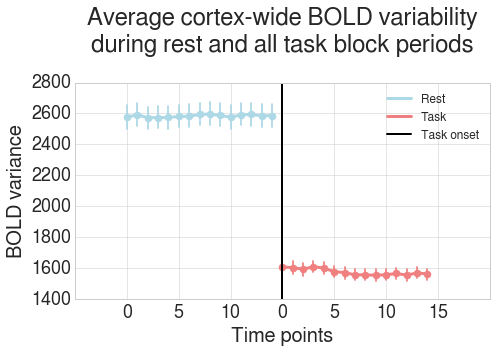

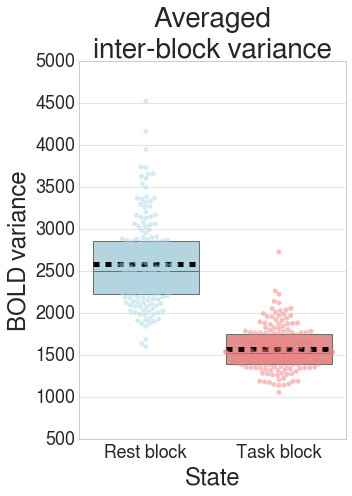

In [1056]:
df_allvar = {}
df_allvar['Subject'] = []
df_allvar['Timepoint'] = []
df_allvar['Variance'] = []
df_allvar['State'] = []
mean_var = np.zeros((len(block_data),len(block_data[0]),min_blocklength*2))
for cond in range(len(block_data)):
    for subj in range(len(block_data[0])):
        mean_var[cond,subj,:] = np.nanmean(np.nanvar(block_data[cond][subj],axis=2),axis=0)
        
mean_var = np.nanmean(mean_var,axis=0)

for s in range(len(subjNums)):
    for tp in range(mean_var.shape[1]):
        if tp<rest_period:
            state='Rest'
#         elif min_blocklength*2>tp>min_blocklength:
#             state='ITI'
        elif tp>=min_blocklength:
            state='Task'
        df_allvar['State'].append(state)
        df_allvar['Subject'].append(s)
        df_allvar['Timepoint'].append(tp)
        df_allvar['Variance'].append(mean_var[s,tp])
            
df_allvar = pd.DataFrame(df_allvar)
        
df_rest = df_allvar.loc[df_allvar.State=='Rest']
df_task = df_allvar.loc[df_allvar.State=='Task']
plt.figure(figsize=(7,5));
sns.regplot(x="Timepoint", y="Variance", data=df_rest, color='#add8e6', x_estimator=np.mean,fit_reg=False);
sns.regplot(x="Timepoint", y="Variance", data=df_task, color='#f08080', x_estimator=np.mean,fit_reg=False);
x = np.arange(mean_var.shape[1])
block_var = np.mean(mean_var,axis=0)
block_var.shape = (1,len(block_var))
# x = np.arange(block_var.shape[1])
x = np.hstack((np.arange(min_blocklength*2)))
plt.plot(x[:min_blocklength],np.mean(block_var[:,:rest_period],axis=0),color='#add8e6',linewidth=3,label='Rest')
plt.plot(x[-min_blocklength:],np.mean(block_var[:,-min_blocklength:],axis=0),color='#f08080',linewidth=3,label='Task')
plt.axvline(x=min_blocklength,color='k',linestyle='-',linewidth=2,label='Task onset');
# plt.axvline(x=rest_period,color='k',linestyle='-',linewidth=3);
plt.xticks(np.hstack((np.arange(0,min_blocklength,5),np.arange(min_blocklength,min_blocklength*2+1,5))),
           np.hstack((np.arange(0,min_blocklength,5),np.arange(0,min_blocklength+1,5))));
plt.legend();
plt.xlabel('Time points',fontsize=20);
plt.ylabel('BOLD variance',fontsize=20);
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Average cortex-wide BOLD variability\nduring rest and all task block periods\n',fontsize=24);
plt.tight_layout()
plt.savefig('fMRI5_SpontaneousVariability_WholeBrain.jpg',dpi=150)



## Boxplot
plt.figure(figsize=(5,7))
# sns.boxplot(data=[np.mean(mean_var[:,:rest_period],axis=1),
#                   np.mean(mean_var[:,rest_period:rest_period+iti_period],axis=1),
#                   np.mean(mean_var[:,-min_blocklength:],axis=1)],
#            palette=["#add8e6","#f08080","#f08080"],
#            meanline=True,showmeans=True,meanprops={'linewidth':5,'color':'k','linestyle':':'},
#            medianprops={'linestyle':'-'},sym='',whis=0)
# sns.swarmplot(data=[np.mean(mean_var[:,:rest_period],axis=1),
#                     np.mean(mean_var[:,rest_period:rest_period+iti_period],axis=1),
#                     np.mean(mean_var[:,-min_blocklength:],axis=1)],
#             palette=["#add8e6","#f08080","#f08080"],
#             alpha=0.5)
sns.boxplot(data=[np.mean(mean_var[:,:min_blocklength],axis=1),
                  np.mean(mean_var[:,-min_blocklength:],axis=1)],
           palette=["#add8e6","#f08080"],
           meanline=True,showmeans=True,meanprops={'linewidth':5,'color':'k','linestyle':'--'},
           medianprops={'linestyle':'-'},sym='',whis=0)
sns.swarmplot(data=[np.mean(mean_var[:,:min_blocklength],axis=1),
                    np.mean(mean_var[:,-min_blocklength:],axis=1)],
            palette=['#add8e6',"#f08080"],
            alpha=0.5)
plt.title('Averaged\ninter-block variance',fontsize=28,fontname='FreeSans')
plt.ylabel('BOLD variance',fontsize=24)
plt.xlabel('State',fontsize=24)
# plt.xticks(np.arange(3),['Rest','ITI','Task block'],fontname='FreeSans',fontsize=18)
plt.xticks(np.arange(2),['Rest block','Task block'],fontname='FreeSans',fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig('fMRI5_SpontaneousVariability_WholeBrain_BoxPlot.jpg',dpi=150)
# t, p = stats.ttest_rel(np.mean(mean_var[:,-min_blocklength:],axis=1),np.mean(mean_var[:,rest_period:rest_period+iti_period],axis=1))
# print('Task versus ITI:', np.mean(mean_var[:,-min_blocklength:]) - np.mean(mean_var[:,rest_period:rest_period+iti_period]),' t =', t, '| p =', p)
t, p = stats.ttest_rel(np.mean(mean_var[:,-min_blocklength:],axis=1),np.mean(mean_var[:,:rest_period],axis=1))
print('Task versus Rest:', np.mean(mean_var[:,-min_blocklength:])-np.mean(mean_var[:,:rest_period]),' t =', t, '| p =', p)
# t, p = stats.ttest_rel(np.mean(mean_var[:,rest_period:rest_period+iti_period],axis=1),np.mean(mean_var[:,:rest_period],axis=1))
# print('ITI versus Rest:', np.mean(mean_var[:,rest_period:rest_period+iti_period])-np.mean(mean_var[:,:rest_period]),' t =', t, '| p =', p)

# Now plot the whole-brain correlation across all ROIs, for every subject

In [1030]:
df_allcorr = {}
df_allcorr['Subject'] = []
df_allcorr['Timepoint'] = []
df_allcorr['Correlation'] = []
df_allcorr['State'] = []
ntps = min_blocklength*2
mean_corr = np.zeros((len(block_data),len(subjNums),ntps))
for cond in range(len(block_data)):
    for s in range(len(subjNums)):
        for tp in range(ntps):
            mean_corr[cond,s,tp] = np.nanmean(np.corrcoef(block_data[cond][s][:,tp,:]))
        

In [1031]:
df_allcorr = {}
df_allcorr['Subject'] = []
df_allcorr['Timepoint'] = []
df_allcorr['Correlation'] = []
df_allcorr['State'] = []
for s in range(len(subjNums)):
    for tp in range(ntps):
        if tp<rest_period:
            state='Rest'
        else:
            state='Task'
        df_allcorr['State'].append(state)
        df_allcorr['Subject'].append(s)
        df_allcorr['Timepoint'].append(tp)
        df_allcorr['Correlation'].append(np.nanmean(mean_corr[:,s,tp],axis=0))
df_allcorr = pd.DataFrame(df_allcorr)
mean_corr_alltasks = np.nanmean(mean_corr,axis=0) # average across conditions

('Task versus Rest:', -0.036114425125021402, ' t =', -10.912004952625574, '| p =', 1.7731257114915267e-21)


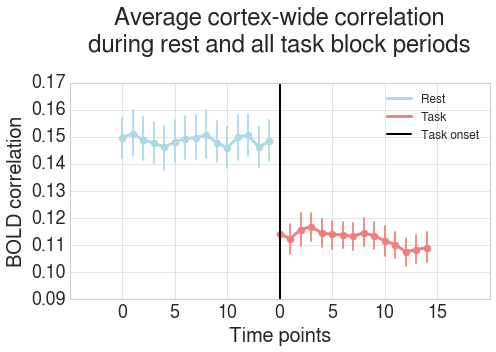

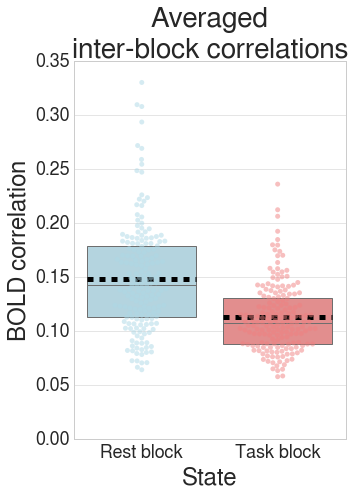

In [1055]:
df_rest = df_allcorr.loc[df_allcorr.State=='Rest']
df_task = df_allcorr.loc[df_allcorr.State=='Task']
plt.figure(figsize=(7,5));
sns.regplot(x="Timepoint", y="Correlation", data=df_rest, color='#add8e6', x_estimator=np.mean,fit_reg=False);
sns.regplot(x="Timepoint", y="Correlation", data=df_task, color='#f08080', x_estimator=np.mean,fit_reg=False);
x = np.arange(mean_corr_alltasks.shape[1])
block_corr = np.mean(mean_corr_alltasks,axis=0)
block_corr.shape = (1,len(block_corr))
plt.plot(x[:rest_period],np.mean(mean_corr_alltasks[:,:min_blocklength],axis=0),color='#add8e6',linewidth=3,label='Rest')
plt.plot(x[rest_period:],np.mean(mean_corr_alltasks[:,min_blocklength:],axis=0),color='#f08080',linewidth=3,label='Task')
plt.axvline(x=min_blocklength,color='k',linestyle='-',linewidth=2,label='Task onset');
# plt.axvline(x=rest_period,color='k',linestyle='-',linewidth=3);
plt.xticks(np.hstack((np.arange(0,min_blocklength,5),np.arange(min_blocklength,min_blocklength*2+1,5))),
           np.hstack((np.arange(0,min_blocklength,5),np.arange(0,min_blocklength+1,5))));
plt.legend();
plt.xlabel('Time points',fontsize=20);
plt.ylabel('BOLD correlation',fontsize=20);
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Average cortex-wide correlation\nduring rest and all task block periods\n',fontsize=24);
plt.tight_layout()
plt.savefig('fMRI5_SpontaneousCorrelation_WholeBrain.jpg',dpi=150)


## Boxplot
plt.figure(figsize=(5,7))
sns.boxplot(data=[np.mean(mean_corr_alltasks[:,:min_blocklength],axis=1),
                  np.mean(mean_corr_alltasks[:,-min_blocklength:],axis=1)],
           palette=["#add8e6","#f08080"],
           meanline=True,showmeans=True,meanprops={'linewidth':5,'color':'k','linestyle':'--'},
           medianprops={'linestyle':'-'},sym='',whis=0)
sns.swarmplot(data=[np.mean(mean_corr_alltasks[:,:min_blocklength],axis=1),
                    np.mean(mean_corr_alltasks[:,-min_blocklength:],axis=1)],
            palette=["#add8e6","#f08080"],
            alpha=0.5)
plt.title('Averaged\ninter-block correlations',fontsize=28,fontname='FreeSans')
plt.ylabel('BOLD correlation',fontsize=24)
plt.xlabel('State',fontsize=24)
plt.xticks(np.arange(2),['Rest block','Task block'],fontname='FreeSans',fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig('fMRI5_SpontaneousCorrelation_WholeBrain_Boxplot.jpg',dpi=150)

# t, p = stats.ttest_rel(np.mean(mean_corr_alltasks[:,-min_blocklength:],axis=1),np.mean(mean_corr_alltasks[:,rest_period:rest_period+iti_period],axis=1))
# print('Task versus ITI:', np.mean(mean_corr_alltasks[:,-min_blocklength:]) - np.mean(mean_corr_alltasks[:,rest_period:rest_period+iti_period]),' t =', t, '| p =', p)
t, p = stats.ttest_rel(np.mean(mean_corr_alltasks[:,-min_blocklength:],axis=1),np.mean(mean_corr_alltasks[:,:min_blocklength],axis=1))
print('Task versus Rest:', np.mean(mean_corr_alltasks[:,-min_blocklength:])-np.mean(mean_corr_alltasks[:,:min_blocklength]),' t =', t, '| p =', p)
# t, p = stats.ttest_rel(np.mean(mean_corr_alltasks[:,rest_period:rest_period+iti_period],axis=1),np.mean(mean_corr_alltasks[:,:rest_period],axis=1))
# print('ITI versus Rest:', np.mean(mean_corr_alltasks[:,rest_period:rest_period+iti_period])-np.mean(mean_corr_alltasks[:,:rest_period]),' t =', t, '| p =', p)